In [1]:
!unzip /content/drive/"My Drive"/"Arrythmia "/ECGDataDenoised.zip
!pip install -q -U tensorflow_addons
!pip install neurokit2

Streaming output truncated to the last 5000 lines.
  inflating: ECGDataDenoised/MUSE_20180116_130048_60000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130105_17000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130110_43000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130111_47000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130121_66000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130122_72000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130134_31000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130256_07000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130257_13000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130310_51000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130314_76000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130315_82000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130318_97000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130320_03000.csv  
  inflating: ECGDataDenoised/MUSE_20180116_130329_14000.csv  
  inflating: ECGDat

In [ ]:
from numpy import array
from sklearn.model_selection import KFold
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from scipy import stats
from scipy import signal
from sklearn.model_selection import train_test_split
import sklearn
import itertools
import tensorflow_addons
from tensorflow_addons.optimizers import CyclicalLearningRate
from tensorflow.keras.callbacks import Callback
import tensorflow_addons as tfa
import matplotlib as mpl
mpl.style.use('seaborn')
plt.rcParams["figure.figsize"] = (13,4)
import matplotlib.pyplot as plt 
import requests
import matplotlib.pyplot as plt
from os import listdir, mkdir, system
from os.path import isfile, isdir, join, exists
import json
from tqdm import tqdm
from matplotlib import collections as matcoll

import neurokit2 as nk

def round_robin(RR_interval):

  RR_interval=RR_interval.tolist()
  wind_size = 100
  data_vect = []
  
  #CREATE DATA VECTOR
  for i in tqdm(range(len(RR_interval))):

    if i < len(RR_interval):

      if len(RR_interval) >= i+wind_size:
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)
      else:
        RR_interval.extend(RR_interval[0:100])
        rr_interval = RR_interval[i:i+wind_size]
        data_vect.append(rr_interval)

  return np.array(data_vect)

def plot_rr(rrintervals,rr_diff):
  x = rrintervals/500
  y = rr_diff
  lines = []
  for i in range(len(x)):
      pair=[(x[i],0), (x[i], y[i])]
      lines.append(pair)

  linecoll = matcoll.LineCollection(lines)
  fig, ax = plt.subplots()
  ax.add_collection(linecoll)

  plt.scatter(x,y)
  plt.xticks(x)
  plt.xlabel("Time (s)")
  plt.ylim(0,1)
  plt.title("RR Peaks")
  plt.show()

# def detect_r_peaks(patient_list,case,showplots=False):
#     parent_folder = '/content/ECGDataDenoised/'
#     data_with_rr = pd.DataFrame()
#     patient_col_id = []
#     case_name = []
#     mxx=0
#     cnt=0
#     mnn=90
#     for i in tqdm(patient_list):
#       # try:
        
#         data = parent_folder+i+".csv"
#         df = pd.read_csv(data,header=None)
#         df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
#         cols = df.columns
#         df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
#         lead_name='II'
#         count = (df[lead_name] == 0).sum()
#         if(count>0):
#           print(count)
#         if(df[lead_name].isnull().sum(axis = 0)>0):
#           print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
#         # Extract R-peaks locations
#         _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
#         rrintervals = rpeaks['ECG_R_Peaks']
#         cnt+=len(rrintervals)-1
        
#         rr_diff=np.diff(rrintervals)/1000
#         rr_diff = np.append(0,rr_diff)

#         mxx=max(len(rr_diff),mxx) #to check maximum number of rr intervals for any signal
#         mnn=min(len(rr_diff),mnn)

#         print(len(rrintervals),len(rr_diff))

#         patient_col_id.append(i)
#         case_name.append(case)
#         data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
#         detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)

#         if(showplots):
#           plot = (nk.events_plot(rpeaks['ECG_R_Peaks'], df["aVL"]))
#           plot_rr(rrintervals,rr_diff)
#           print("DETRENDED")
#           plot_rr(rrintervals,detrended_rri)
          
#       # except:
#       #   print("\nError in:",i)
#     print("\n",case,"    ****Max****:",mxx)
#     print("\n",case,"    ****Min****:",mnn,"\n")
#     print("Total no. of RR Intervals in",case," class is:",cnt,"\n")
#     data_with_rr['filename']=patient_col_id
#     data_with_rr['label']=case_name
#     return data_with_rr  #returning data containing RR Intervals with label

def append_r_peaks(patient_list,case,sampling_rate=500,showplots=False):
    rr_ints=[]
    rri_with_patient_id = {}
    parent_folder = '/content/ECGDataDenoised/'
    data_with_rr = pd.DataFrame()
    patient_col_id = []
    
    cnt=0
    for i in tqdm(patient_list):
      try:
        data = parent_folder+i+".csv"
        df = pd.read_csv(data,header=None)
        df.columns=['I','II','III','aVR','aVL','aVF','V1','V2','V3','V4','V5','V6']
        cols = df.columns
        df[cols[:-1]] = df[cols[:-1]].apply(pd.to_numeric, errors='coerce')
        lead_name='II'
        count = (df[lead_name] == 0).sum()
        if(count>0):
          print(count)
        if(df[lead_name].isnull().sum(axis = 0)>0):
          print("Null values in ",i,"is :",df[lead_name].isnull().sum(axis = 0))
        # Extract R-peaks locations
        _, rpeaks = nk.ecg_peaks(df["II"][1:], sampling_rate=500)
        rrintervals = rpeaks['ECG_R_Peaks']
        cnt+=len(rrintervals)-1
        
        rr_diff=np.diff(rrintervals)/1000
        # rr_diff = np.append(0,rr_diff) #adding this 0 for equal size of RRi , hence to plot
        rr_ints = np.append(rr_ints,rr_diff)
        patient_col_id.append(i)
        # case_name.append(case)
        data_with_rr=data_with_rr.append(pd.DataFrame(rr_diff).transpose())
        detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
        rri_with_patient_id[i]=detrended_rri
      except:
        print("\nError in:",i)

    print("Total no. of RR Intervals in",case," class is:",len(rr_ints),"\n")
    return rri_with_patient_id  #returning data containing RR Intervals with label

def pretty_plot(history, field, fn):
  def plot(data, val_data, best_index, best_value, title):
    plt.plot(range(1, len(data)+1), data, label='train')
    plt.plot(range(1, len(data)+1), val_data, label='validation')
    if not best_index is None:
      plt.axvline(x=best_index+1, linestyle=':', c="#777777")
    if not best_value is None:
      plt.axhline(y=best_value, linestyle=':', c="#777777")
    plt.xlabel('Epoch')
    plt.ylabel(field)
    plt.xticks(range(0, len(data), 20))
    plt.title(title)
    plt.legend()
    plt.show()

  data = history.history[field]
  val_data = history.history['val_' + field]
  tail = int(0.15 * len(data))

  best_index = fn(val_data)
  best_value = val_data[best_index]

  plot(data, val_data, best_index, best_value, "{} over epochs (best {:06.4f})".format(field, best_value))
  plot(data[-tail:], val_data[-tail:], None, best_value, "{} over last {} epochs".format(field, tail))

class LRFinder(Callback):
    """`Callback` that exponentially adjusts the learning rate after each training batch between `start_lr` and
    `end_lr` for a maximum number of batches: `max_step`. The loss and learning rate are recorded at each step allowing
    visually finding a good learning rate as per https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html via
    the `plot` method.
    """

    def __init__(self, start_lr: float = 1e-2, end_lr: float = 10, max_steps: int = 100, smoothing=0.9):
        super(LRFinder, self).__init__()
        self.start_lr, self.end_lr = start_lr, end_lr
        self.max_steps = max_steps
        self.smoothing = smoothing
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_begin(self, logs=None):
        self.step, self.best_loss, self.avg_loss, self.lr = 0, 0, 0, 0
        self.lrs, self.losses = [], []

    def on_train_batch_begin(self, batch, logs=None):
        self.lr = self.exp_annealing(self.step)
        tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)

    def on_train_batch_end(self, batch, logs=None):
        logs = logs or {}
        loss = logs.get('loss')
        step = self.step
        if loss:
            self.avg_loss = self.smoothing * self.avg_loss + (1 - self.smoothing) * loss
            smooth_loss = self.avg_loss / (1 - self.smoothing ** (self.step + 1))
            self.losses.append(smooth_loss)
            self.lrs.append(self.lr)

            if step == 0 or loss < self.best_loss:
                self.best_loss = loss

            if smooth_loss > 4 * self.best_loss or tf.math.is_nan(smooth_loss):
                self.model.stop_training = True

        if step == self.max_steps:
            self.model.stop_training = True

        self.step += 1

    def exp_annealing(self, step):
        return self.start_lr * (self.end_lr / self.start_lr) ** (step * 1. / self.max_steps)

    def plot(self):
        fig, ax = plt.subplots(1, 1)
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate (log scale)')
        ax.set_xscale('log')
        ax.xaxis.set_major_formatter(plt.FormatStrFormatter('%.0e'))
        ax.plot(self.lrs, self.losses)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def get_base_model(categories=2):
  return keras.Sequential([
    keras.layers.Dense(10, activation='relu', input_shape=[100], kernel_regularizer=regularizers.l2(0.001)),
    # keras.layers.Dense(25, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    keras.layers.Dense(3, activation='relu'),
    (keras.layers.Dense(1, activation='sigmoid') if categories == 2 else keras.layers.Dense(5, activation='softmax'))                   
  ])


def get_resnet_model(categories=2): #original
  def residual_block(X, kernels, stride):
    out = keras.layers.Conv1D(64,kernels, stride, padding='same')(X)
    # out = keras.layers.ReLU()(out)
    # out = keras.layers.Conv1D(kernels, stride, padding='same')(out)
    out = keras.layers.add([X, out])
    out = keras.layers.ReLU()(out)
    out = keras.layers.MaxPool1D(1, 2)(out)
    return out

  kernels = 32
  stride = 1

  inputs = keras.layers.Input([100,1])
  X = keras.layers.Conv1D(64,kernels, stride)(inputs)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = residual_block(X, kernels, stride)
  X = keras.layers.Flatten()(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  X = keras.layers.Dense(32, activation='relu')(X)
  output = (keras.layers.Dense(1, activation='sigmoid')(X) if categories == 2 else keras.layers.Dense(5, activation='softmax')(X))

  model = keras.Model(inputs=inputs, outputs=output)
  return model

print("File Import Success")                        

In [32]:
def extractor(case,id):
  cnt_id={}
  nsr_det_rri = []
  nsr_det_rri = np.array(nsr_det_rri)
  afib_det_rri = []
  afib_det_rri = np.array(afib_det_rri)
  afl_det_rri = []
  afl_det_rri = np.array(afl_det_rri)
  afl_list = []
  for i in id:
    label=subject_label[all_subjects[i]]
    if label in cnt_id:
      cnt_id[label]+=1
    else:
      cnt_id[label]=1
    name=all_subjects[i]
    if(label=='nsr'):
      nsr_det_rri=np.append(nsr_det_rri,nsr_rri[name])
    elif(label=='afl'):
      afl_list.append(name)
      afl_det_rri=np.append(afl_det_rri,afl_rri[name])
    else:
      afib_det_rri=np.append(afib_det_rri,afib_rri[name])
    ## 
  print(case,":",cnt_id)
  print(len(afib_det_rri),len(nsr_det_rri),len(afl_det_rri))

  p1 = np.random.permutation(afl_list)
  p2 = np.random.permutation(afl_list)
  # print(len(p1)," , ",len(p2))
  for k in p1:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  for k in p2:
    afl_det_rri=np.append(afl_det_rri,afl_rri[k])
  print("After patient Scrambling:",len(afl_det_rri))


  afib_vectors = round_robin(afib_det_rri)
  afl_vectors = round_robin(afl_det_rri)
  nsr_vectors = round_robin(nsr_det_rri)
  len__puncture = min(len(afib_vectors),min(len(nsr_vectors),len(afl_vectors)))
  afib_vectors = afib_vectors[:len__puncture]
  afl_vectors = afl_vectors[:len__puncture]
  nsr_vectors = nsr_vectors[:len__puncture]

  afib_rr = pd.DataFrame(afib_vectors)
  afib_rr['label']='afib'
  nsr_rr = pd.DataFrame(nsr_vectors)
  nsr_rr['label']='nsr'
  afl_rr = pd.DataFrame(afl_vectors)
  afl_rr['label']='afl'

  afl_rr = afl_rr.sample(frac=0.5).reset_index(drop=True)
  afib_rr = afib_rr.sample(frac=0.5).reset_index(drop=True)

  full_data_with_rr=pd.concat([afib_rr,nsr_rr,afl_rr])
  dict = {'nsr': 0, 'afib': 1, 'afl':1}
  full_data_with_rr.replace({'label': dict},inplace=True)
  return full_data_with_rr



def train_1_fold(train,test,NN):
    # train=pd.read_csv("/content/drive/MyDrive/train_with_rr_20.csv")
    train = train.sample(frac=1).reset_index(drop=True)
    train = train.sample(frac=1).reset_index(drop=True)
    full_data_with_rr=train
    full_test_set=test

    X_arhy_train, X_arhy_val, y_arhy_train, y_arhy_val = train_test_split(full_data_with_rr.iloc[:,:-1].values, full_data_with_rr.iloc[:,-1].values,test_size=0.1, random_state=42)

    X_arhy_test, X_arhy_val, y_arhy_test, y_arhy_val = train_test_split(X_arhy_val,y_arhy_val,test_size=0.5, random_state=42)

    # The 1D convolutions expect an extra dimension in the input data 
    X_arhyl_train = np.expand_dims(X_arhy_train, -1)
    y_arhyl_train = np.expand_dims(y_arhy_train, -1)
    X_arhyl_val = np.expand_dims(X_arhy_val, -1)
    y_arhyl_val = np.expand_dims(y_arhy_val, -1)
    X_arhyl_test = np.expand_dims(X_arhy_test, -1)
    y_arhyl_test = np.expand_dims(y_arhy_test, -1)

    N = X_arhyl_train.shape[0]
    batch_size = 128
    iterations = N/batch_size
    step_size= 2 * iterations

    optimizer = keras.optimizers.Adam(lr=0.001)
    model = get_resnet_model(5) 
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    lr_finder = LRFinder(start_lr=1e-7, end_lr= 1e-02, max_steps=50, smoothing=0.6)
    _ = model.fit(X_arhyl_train, y_arhyl_train, batch_size=256, epochs=5, callbacks=[lr_finder], verbose=False)
    lr_finder.plot()

    lr_schedule = CyclicalLearningRate(1e-5, 1e-2, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
    
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
    m_resnet_model = get_resnet_model(NN)

    save_best_weights = ModelCheckpoint(filepath="/content/drive/My Drive/Arrythmia /weights_2.hdf5", verbose=0, save_best_only=True)

    m_resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = m_resnet_model.fit(X_arhyl_train, y_arhyl_train, validation_data=(X_arhyl_val, y_arhyl_val), 
                                shuffle=True, batch_size=128, epochs=8, callbacks=[save_best_weights])
    pretty_plot(history, 'loss', lambda x: np.argmin(x))
    pretty_plot(history, 'accuracy', lambda x: np.argmax(x))
    m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights_2.hdf5")
    print("\n****** Val data (used to tune hyperparameters for model) *****\n")
    test_stats = m_resnet_model.evaluate(X_arhyl_test, y_arhyl_test)   
    test_acc = round(test_stats[1],2)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhyl_test), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR','Arrhythmia'],
                        title='Confusion matrix, without normalization')

    X_arhy_test_10split = full_test_set.iloc[:,:-1].values
    y_arhy_test_10split = full_test_set.iloc[:,-1].values

    print("\n****** Validation data (unseen to model) *****\n")
    ###########
    val_stats=m_resnet_model.evaluate(X_arhy_test_10split, y_arhy_test_10split)
    val_acc = round(val_stats[1],4)
    
    y_pred = tf.argmax(m_resnet_model.predict(X_arhy_test_10split), axis=-1)
    # Compute confusion matrix
    cnf_matrix = sklearn.metrics.confusion_matrix(y_arhy_test_10split, y_pred)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=['NSR','Arrhythmia'],
                        title='Confusion matrix, without normalization')
    
    print("Final Accuracy:",val_acc*100,"%\n")
    return float(val_acc*100)


In [26]:
labels = pd.read_excel('/content/drive/MyDrive/Arrythmia /Diagnostics.xlsx')
len(labels)
labels=labels[(labels['Rhythm']=='AFIB') | (labels['Rhythm']=='AF') |(labels['Rhythm']=='SR')]
labels.reset_index(inplace=True,drop=True)
labels['Rhythm'].value_counts()

SR      1826
AFIB    1780
AF       445
Name: Rhythm, dtype: int64

In [27]:
afib_files = labels[labels['Rhythm']=="AFIB"]['FileName'].tolist()
afib_files.remove('MUSE_20180116_131253_72000')
nsr_files = labels[labels['Rhythm']=="SR"]['FileName'].tolist()
afl_files = labels[labels['Rhythm']=="AF"]['FileName'].tolist()
all_files = afib_files+nsr_files+afl_files

In [9]:
nsr_rri=append_r_peaks(nsr_files,"nsr",sampling_rate=500)
afib_rri=append_r_peaks(afib_files,"afib",sampling_rate=500)
afl_rri=append_r_peaks(afl_files,"afl",sampling_rate=500)

100%|██████████| 1826/1826 [00:43<00:00, 41.87it/s]


Total no. of RR Intervals in nsr  class is: 20520 



 91%|█████████ | 1620/1779 [00:41<00:04, 39.20it/s]/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
100%|██████████| 1779/1779 [00:45<00:00, 39.09it/s]


Total no. of RR Intervals in afib  class is: 25124 



100%|██████████| 445/445 [00:10<00:00, 40.48it/s]

Total no. of RR Intervals in afl  class is: 7491 



In [10]:
all_subjects=all_files
subject_label = {}
for i in afib_files:
    subject_label[i] = 'afib'
for i in nsr_files:
    subject_label[i] = 'nsr'
for i in afl_files:
    subject_label[i] = 'afl'

train : {'afib': 1592, 'nsr': 1652, 'afl': 401}
22573 18567 6786
After patient Scrambling: 20358


100%|██████████| 18567/18567 [00:00<00:00, 445974.62it/s]


test : {'afib': 187, 'nsr': 174, 'afl': 44}
2551 1953 705
After patient Scrambling: 2115


100%|██████████| 1953/1953 [00:00<00:00, 164259.88it/s]



#@#@#@#@#@ Working on FOLD: 1 #@#@#@#@#@



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/8
262/262 [==============================] - 12s 35ms/step - loss: 0.3008 - accuracy: 0.8747 - val_loss: 0.0890 - val_accuracy: 0.9693
Epoch 2/8
262/262 [==============================] - 6s 25ms/step - loss: 0.0912 - accuracy: 0.9697 - val_loss: 0.0991 - val_accuracy: 0.9742
Epoch 3/8
262/262 [==============================] - 7s 26ms/step - loss: 0.0519 - accuracy: 0.9841 - val_loss: 0.0370 - val_accuracy: 0.9898
Epoch 4/8
262/262 [==============================] - 6s 25ms/step - loss: 0.0174 - accuracy: 0.9943 - val_loss: 0.0149 - val_accuracy: 0.9952
Epoch 5/8
262/262 [==============================] - 6s 24ms/step - loss: 0.0100 - accuracy: 0.9969 - val_loss: 0.0352 - val_accuracy: 0.9925
Epoch 6/8
262/262 [==============================] - 6s 24ms/step - loss: 0.0356 - accuracy: 0.9899 - val_loss: 0.0704 - val_accuracy: 0.9871
Epoch 7/8
262/262 [==============================] - 6s 24ms/step - loss: 0.0618 - accuracy: 0.9823 - val_loss: 0.0213 - val_accuracy: 0.9952
Epoch

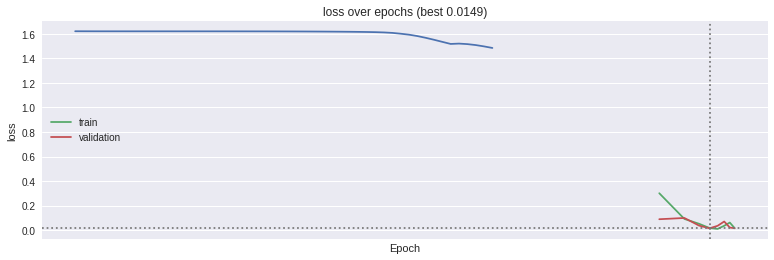

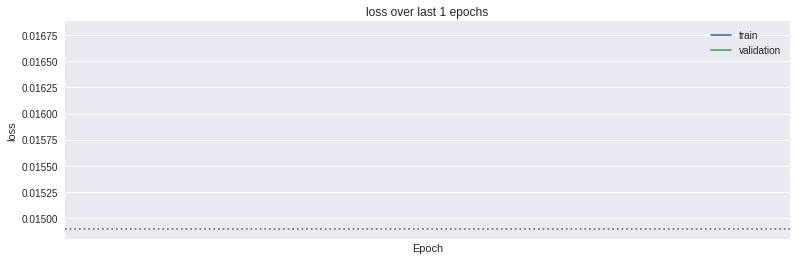

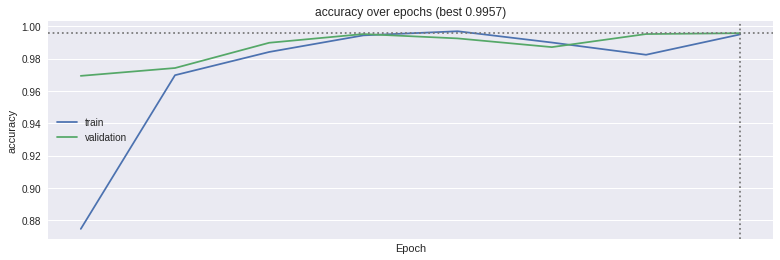

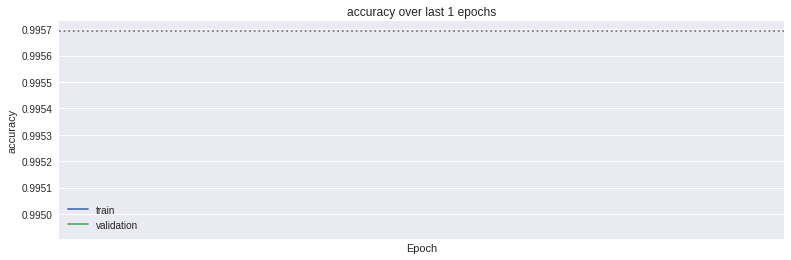


****** Val data (used to tune hyperparameters for model) *****

59/59 [==============================] - 0s 8ms/step - loss: 0.0074 - accuracy: 0.9978
Confusion matrix, without normalization
[[921   1]
 [  3 932]]

****** Validation data (unseen to model) *****

123/123 [==============================] - 1s 8ms/step - loss: 0.2206 - accuracy: 0.9654
Confusion matrix, without normalization
[[1844  109]
 [  26 1926]]
Final Accuracy: 96.54 %

10 fold acc: [96.54]


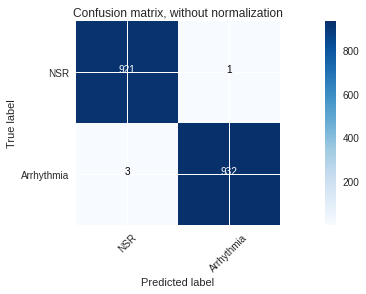

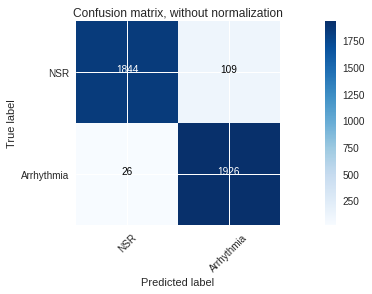

In [33]:
# scikit-learn k-fold cross-validation
data=all_subjects

# prepare cross validation
kfold = KFold(10,shuffle=True,random_state=42)
all_fold_acc = []
# enumerate splits
count=1
for train, test in kfold.split(data):  
  full_train_set = extractor("train",train)
  full_test_set = extractor("test",test)
  print("\n#@#@#@#@#@ Working on FOLD:",count,"#@#@#@#@#@\n")
  accuracy_1_fold = train_1_fold(full_train_set,full_test_set,7)
  all_fold_acc.append(accuracy_1_fold)
  count+=1
  #1 fold done call rest part in function to complete your k fold cv
  break
print("10 fold acc:",all_fold_acc)

In [ ]:
!wget -r -N -c -np https://physionet.org/files/ptbdb/1.0.0/
!pip install wfdb
import wfdb #WaveForm-Database package. A library of tools for reading, writing, and processing WFDB signals and annotations.
import pandas as pd
import numpy as np
import sys
import glob
import os
from glob import glob
PATH = "/content/physionet.org/files/ptbdb/1.0.0/"
sys.path.append(os.path.abspath(PATH))

nsr_patients =['patient104/s0306lre','patient105/s0303lre','patient116/s0302lre','patient117/s0291lre','patient117/s0292lre',
               
      'patient121/s0311lre','patient122/s0312lre','patient131/s0273lre','patient150/s0287lre','patient155/s0301lre',
      'patient156/s0299lre','patient165/s0322lre','patient165/s0323lre','patient166/s0275lre','patient169/s0328lre',
      'patient169/s0329lre','patient170/s0274lre','patient172/s0304lre','patient173/s0305lre','patient174/s0300lre',
      'patient174/s0324lre','patient174/s0325lre','patient180/s0374lre','patient180/s0475_re','patient180/s0476_re',
      'patient180/s0477_re','patient180/s0490_re','patient180/s0545_re','patient180/s0561_re','patient182/s0308lre',
      'patient184/s0363lre','patient185/s0336lre','patient198/s0402lre','patient198/s0415lre','patient214/s0436_re',
      'patient229/s0452_re','patient229/s0453_re','patient233/s0457_re','patient233/s0458_re','patient233/s0459_re','patient233/s0482_re','patient233/s0483_re','patient234/s0460_re','patient235/s0461_re','patient236/s0462_re','patient236/s0463_re','patient236/s0464_re','patient237/s0465_re','patient238/s0466_re','patient239/s0467_re','patient240/s0468_re','patient241/s0469_re','patient241/s0470_re','patient242/s0471_re','patient243/s0472_re','patient244/s0473_re','patient245/s0474_re','patient245/s0480_re','patient246/s0478_re','patient247/s0479_re','patient248/s0481_re','patient251/s0486_re','patient251/s0503_re','patient251/s0506_re','patient252/s0487_re','patient255/s0491_re','patient260/s0496_re','patient263/s0499_re','patient264/s0500_re','patient266/s0502_re','patient267/s0504_re','patient276/s0526_re','patient277/s0527_re','patient279/s0531_re','patient279/s0532_re','patient279/s0533_re','patient279/s0534_re','patient284/s0543_re','patient284/s0551_re','patient284/s0552_re']

In [ ]:
files = nsr_patients

for i in tqdm(range(0,len(files))):
	recordname=PATH+str(files[i])+'.hea'
	
	recordname_new=recordname[-23:-4] #Extracting just the filename part (will differ from database to database)
	# print(recordname_new)
	record = wfdb.rdsamp(PATH+recordname_new) # rdsamp() returns the signal as a numpy array  
	record=np.asarray(record[0])
	path=PATH+recordname_new+".csv"
	np.savetxt(path,record,delimiter=",") #Writing the CSV for each record
	
print("\nAll files done!")


In [40]:
methods=["interpolation","FFT","poly","numpy"]
m_resnet_model = get_resnet_model(7)
m_resnet_model.load_weights("/content/drive/My Drive/Arrythmia /weights_2.hdf5")
for way in methods:
  print("Using",way,"method of Resampling\n")
  filenames=[]
  li=[]
  for i in tqdm(range(0,len(files))):
    recordname=PATH+str(files[i])+'.csv'
    df=pd.read_csv(recordname,header=None)
    lead_II = df.iloc[:,1] #lead II
    lead_II = nk.signal_resample(lead_II, method=way,
                                              sampling_rate=1000, desired_sampling_rate=500)
    _, rpeaks = nk.ecg_peaks(lead_II, sampling_rate=500)
    rrintervals = rpeaks['ECG_R_Peaks']

    rr_diff=np.diff(rrintervals)/1000
    detrended_rri = signal.detrend(rr_diff, axis= -1, type='constant', bp=0, overwrite_data=False)
    new_df=pd.DataFrame(detrended_rri).transpose()
    li.append(new_df)
    filenames.append(files[i])
    
  test_data = pd.concat(li, axis=0, ignore_index=True)
  test_data=test_data.loc[:,:99]
  test_data['filename']=filenames 

  print("Dropping:",test_data.shape[0] - test_data.dropna().shape[0]," rows.\n")
  #hence 81 files have null values, will drop them
 
  test_data=test_data.dropna()
  test_data.reset_index(inplace=True,drop=True)

  X_ckecker=test_data.iloc[:,:-1].values
  preds=tf.argmax(m_resnet_model.predict(X_ckecker), axis=-1)

  test_data['predicted_class']=preds
  dct= {0:'nsr', 1:'arrhyhthmia'}
  test_data=test_data.replace({"predicted_class": dct})
  print("#### RESULTS ####\n",test_data['predicted_class'].value_counts(),"\n")

Using interpolation method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            46
arrhyhthmia    32
Name: predicted_class, dtype: int64 

Using FFT method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.52it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            46
arrhyhthmia    32
Name: predicted_class, dtype: int64 

Using poly method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.54it/s]


Dropping: 2  rows.

#### RESULTS ####
 nsr            46
arrhyhthmia    32
Name: predicted_class, dtype: int64 

Using numpy method of Resampling



100%|██████████| 80/80 [00:31<00:00,  2.54it/s]

Dropping: 2  rows.

#### RESULTS ####
 nsr            46
arrhyhthmia    32
Name: predicted_class, dtype: int64 

